In [1]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.notebook import tqdm

%matplotlib inline
sns.set()

This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

In [2]:
# подключаем окружение
env = gym.make('Taxi-v3') #gym.make('GuessingGame-v0')

# количество эпизодов
episodes = 5000

# Гиперпараметры
gamma = 0.95 # Коэффициент дисконтирования 
learning_rate = 0.1 # Коэффициент скорости обучения
epsilon = 0.1 # Вероятность выбора случайного действия
max_epsilon = 1
min_epsilon = 0.01
decay = 0.01  

In [3]:
print("Observation Space: ", env.observation_space)
print("Action Space       ", env.action_space)

Observation Space:  Discrete(500)
Action Space        Discrete(6)


In [4]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(1.1)

def view_policy(policy):
    penalties, reward = 0, 0

    frames = []

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[0][curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    
    print_frames(frames)

In [5]:
def Q_Learning(learning_rate, gamma, epsilon, max_epsilon, min_epsilon, decay):
    
    Q = np.zeros([env.observation_space.n, env.action_space.n])

    training_rewards = []  
    epsilons = []
    episode_frames = []

    for episode in tqdm(range(episodes)):
        frames = []

        # начинаем эпизод
        observation = env.reset()
        total_reward = 0
        penalties = 0
        done = False

        while not done:

            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Исследуем
            else:
                action = np.argmax(Q[observation]) # Следуем изученной политике

            new_state, reward, done, info = env.step(action)

            if reward == -10:
                penalties += 1

            frames.append({
                'frame': env.render(mode='ansi'),
                'state': new_state,
                'action': action,
                'reward': reward
                })

            old_value = Q[observation, action]
            next_max = np.max(Q[new_state])
            
            new_value = old_value + learning_rate * (reward + gamma * next_max) - old_value
            Q[observation, action] = new_value

            observation = new_state
            total_reward += reward
        
        training_rewards.append(total_reward)
        episode_frames.append(frames)
                                
        # Сокращаем исследовательский процесс за счет уменьшения эпсилон
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        epsilons.append(epsilon)

    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  # Проходим по каждому состоянию
        best_action = np.argmax(Q[state]) # Находим лучшее действие
        policy[state] = np.eye(env.env.nA)[best_action]
    
    return Q, episode_frames, training_rewards, epsilons, policy

In [6]:
Q_QL, episode_frames_QL, training_rewards_QL, epsilons_QL, policy_QL = Q_Learning(learning_rate, gamma, epsilon, max_epsilon, min_epsilon, decay)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
view_policy([policy_QL])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 12
State: 85
Action: 5
Reward: 20


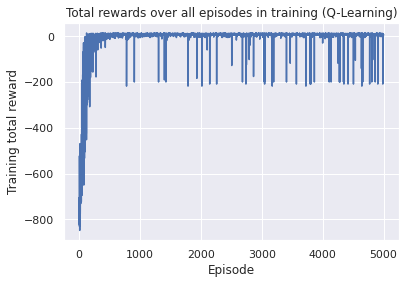

In [8]:
plt.plot(range(episodes), training_rewards_QL)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training (Q-Learning)') 
plt.show()

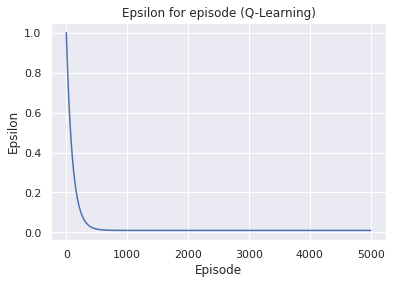

In [9]:
plt.plot(epsilons_QL)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode (Q-Learning)")
plt.show()

In [10]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    # Возвращает вероятности каждого действия
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  
        best_action = np.argmax(Q[obs])  # Берем лучшее действие
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

In [11]:
def SARSA(env, episodes, epsilon, alpha, gamma):
    
    # Создаем Q таблицу
    Q = np.zeros([env.observation_space.n, env.action_space.n])

    # Инициализируем политику
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)

    for i in tqdm(range(episodes)):

        curr_state = env.reset()
        probs = pol(curr_state)   # Возвращаем политику
        curr_act = np.random.choice(np.arange(len(probs)), p=probs)

        while True:
            next_state,reward,done,_ = env.step(curr_act)
            next_probs = create_epsilon_greedy_action_policy(env,Q,epsilon)(next_state)
            next_act = np.random.choice(np.arange(len(next_probs)),p=next_probs)
            td_target = reward + gamma * Q[next_state][next_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
            
            if done:
                break
            
            curr_state = next_state
            curr_act = next_act

    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  # Проходим по каждому состоянию
        best_action = np.argmax(Q[state]) # Находим лучшее действие
        policy[state] = np.eye(env.env.nA)[best_action]

    return Q, policy

In [12]:
env.reset()
Q_SARSA, policy_SARSA = SARSA(env, episodes, epsilon, learning_rate, gamma)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
view_policy([policy_SARSA])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 6
State: 0
Action: 5
Reward: 20
